In [8]:
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
from pathlib import Path
from typing import Iterable, Literal

plt.style.use("ggplot")
plt.style.use("../my.mplstyle")

In [2]:
PROJECT_ROOT = Path.cwd().parent.resolve()
RESULTS_DIR = PROJECT_ROOT/"analysis_results"

LARGELY_SAMPLED_EPITOPES = (
    # "CINGVCWTV",
    "GILGFVFTL",
    # "GLCTLVAML",
    # "LLWNGPMAV",
    "NLVPMVATV",
    "SPRWYFYYL",
    "TFEYVSQPFLMDLE",
    "TTDPSFLGRY",
    "YLQPRTFLL"
)

In [3]:
class ModelToPlot:
    def __init__(self, model_name: str, colour: str, marker: str) -> None:
        self.name = model_name
        self.colour = colour
        self.marker = marker
    
    def load_data(self, task_name: str) -> DataFrame:
        path_to_csv = RESULTS_DIR/self.name/f"{task_name}.csv"
        return pd.read_csv(path_to_csv)

In [4]:
MODELS_OF_INTEREST = (
    ModelToPlot("AB SCEPTR", "#7048e8", "d"),
    ModelToPlot("tcrdist", "#f03e3e", "o"),
    ModelToPlot("CDR Levenshtein", "#f76707", "v"),
    ModelToPlot("CDR3 Levenshtein", "#f59f00", "^"),
    ModelToPlot("TCR BERT", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "#37b24d", "p"),
    ModelToPlot("ProtBert", "#0ca678", "x"),
    # "AB SCEPTR (CDR3 only)",
    # "AB SCEPTR (MLM only)",
    # "AB SCEPTR (CDR3 only, MLM only)"
)

In [5]:
def load_data(model_name: str, task_name: str) -> DataFrame:
    path_to_csv = RESULTS_DIR/model_name/f"{task_name}.csv"
    df = pd.read_csv(path_to_csv)
    return df

In [55]:
def plot_ovr_nn_summary_figure(models: Iterable[ModelToPlot]) -> Figure:
    num_shots = [1, 2, 5, 10, 20, 50, 100, 200]
    
    fig, ax = plt.subplots(figsize=(7,5))

    for model in models:
        ax.plot(get_model_ovr_nn_summary(model, num_shots), f"{model.marker}-", c=model.colour, label=model.name)

    ax.set_ylabel("Average AUC")
    ax.set_xlabel("Number of Shots")
    ax.set_xticks(range(8), [1, 2, 5, 10, 20, 50, 100, 200])

    ax.legend()
    fig.tight_layout()

    return fig    


def get_model_ovr_nn_summary(model: ModelToPlot, num_shots: Iterable[int]) -> ndarray:
    results = [model.load_data(get_ovr_task_name(k)) for k in num_shots]
    avg_aucs = [df[df["epitope"].map(lambda x: x in LARGELY_SAMPLED_EPITOPES)]["mean_auc"].mean() for df in results]
    return np.array(avg_aucs)


def get_ovr_task_name(k: int) -> str:
    if k == 1:
        return "one_vs_rest_1_shot"
    return f"one_vs_rest_{k}_shot_nn"


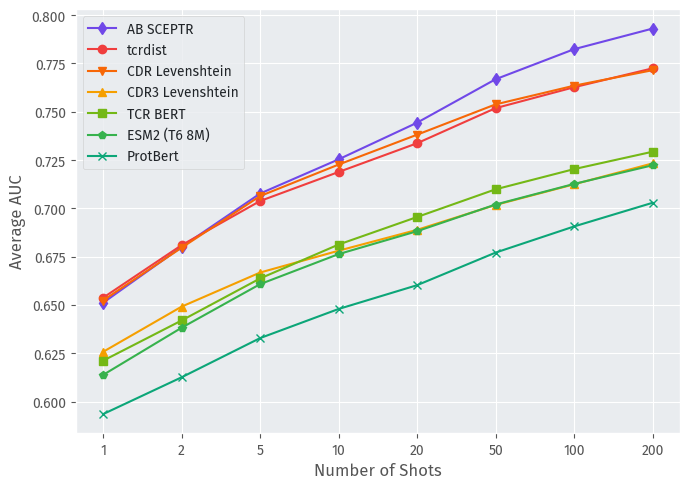

In [56]:
fig = plot_ovr_nn_summary_figure(MODELS_OF_INTEREST)

In [53]:
def plot_predetermined_split_results(models: Iterable[ModelToPlot], classification_method: Literal["nn", "avg_dist"]) -> Figure:
    aucs_per_model = [model.load_data(f"one_vs_rest_predetermined_split_{classification_method}").set_index("epitope") for model in models]
    
    for model, aucs in zip(models, aucs_per_model):
        aucs.columns = [model.name]
    
    aucs_per_model = pd.concat(aucs_per_model, axis="columns")
    aucs_per_model["avg"] = aucs_per_model.apply(lambda row: row.mean(), axis="columns")
    aucs_per_model = aucs_per_model.sort_values(by="avg", ascending=False)

    fig, ax = plt.subplots()

    for model in models:
        ax.plot(aucs_per_model[model.name], f"{model.marker}-", c=model.colour, label=model.name)

    ax.set_ylabel("AUC")
    ax.set_xlabel("Epitope")

    ax.legend()
    fig.tight_layout()

    return fig

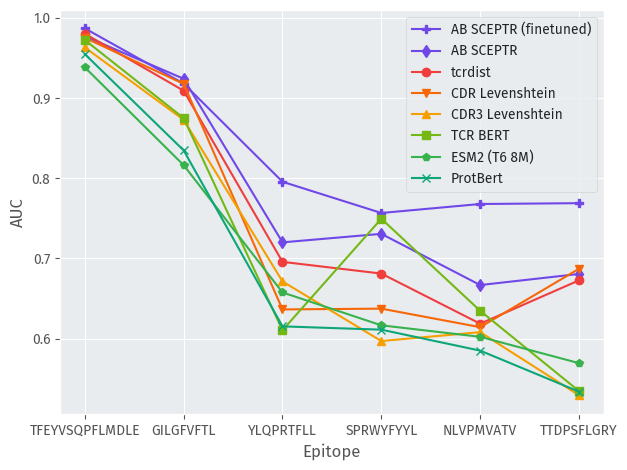

In [54]:
fig = plot_predetermined_split_results((ModelToPlot("AB SCEPTR (finetuned)", "#7048e8", "P"), *MODELS_OF_INTEREST), "nn")

In [ ]:
def plot_auc_distributions(model_names: Iterable[str], task_name: str) -> Figure:
    benchmark_results_per_model = {
        model_name: load_data(model_name, task_name) for model_name in model_names
    }
    mean_aucs_per_model = {
        model_name: df["mean_auc"] for model_name, df in benchmark_results_per_model.items()
    }

    fig, ax = plt.subplots()

    ax.set_title(task_name)
    ax.boxplot(x=mean_aucs_per_model.values(), labels=mean_aucs_per_model.keys(), showmeans=True, meanline=True)
    ax.plot(range(1, 1+len(mean_aucs_per_model)), mean_aucs_per_model.values(), "x--", alpha=0.3)

    return fig

In [132]:
def generate_pgen_density_plot(model_name: str) -> Figure:
    pgen_nn_dists = load_data(model_name, "pgen_nn_dists")
    log10_pgens = np.log10(pgen_nn_dists["pgen"])
    bins = range(-20, -14)
    bin_positions = range(len(bins) + 1)
    nn_dists_by_pgen = bin_dists_by_pgen(pgen_nn_dists["nn_dist"], log10_pgens, bins)

    fig, ax = plt.subplots()
    ax.boxplot(nn_dists_by_pgen, positions=bin_positions)

    bin_labels = ["$<10^{" + str(bins[0]) + "}$"]
    bin_labels += [
        "$10^{" + str(bins[i]) + "}-10^{" + str(bins[i + 1]) + "}$"
        for i in range(len(bins) - 1)
    ]
    bin_labels += ["$>10^{" + str(bins[-1]) + "}$"]

    ax.set_xticks(bin_positions)
    ax.set_xticklabels(bin_labels, rotation=45, ha="right")

    fig.tight_layout()

def bin_dists_by_pgen(dists, pgens, bins) -> list:
    binned_data = [[] for _ in range(len(bins) + 1)]

    inds = np.digitize(pgens, bins)
    for value, ind in zip(dists, inds):
        binned_data[ind].append(value)

    return binned_data

/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


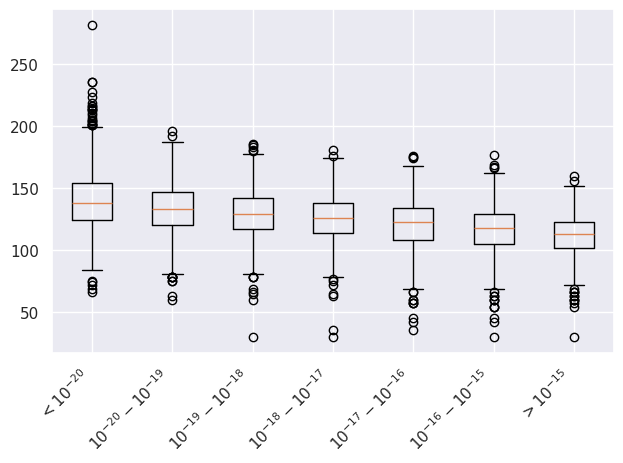

In [133]:
generate_pgen_density_plot("tcrdist")

/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


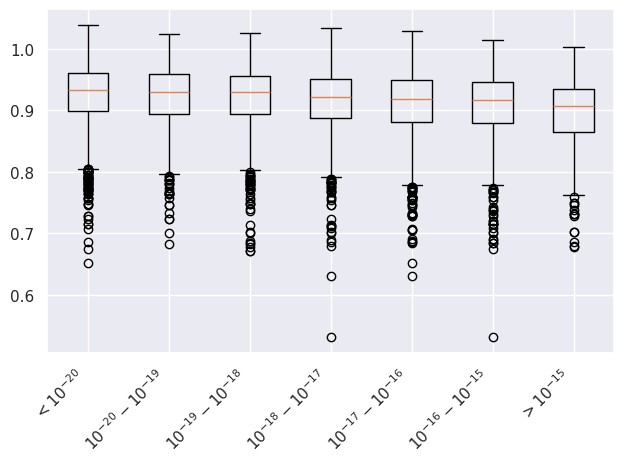

In [134]:
generate_pgen_density_plot("AB SCEPTR")